In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy import sparse
import skbio as sb
import subprocess as sp
import xml.parsers.expat as expat

import sys

%matplotlib inline
pd.set_option('display.max_rows', None)  # or 1000
display(HTML("<style>.container { width:90% !important; }</style>"))

def extract_ids(path: str, title: str):
    files = glob.glob(f"{path}/{title}_*_profile.txt")
    ids = [ re.search(r".+_(.+)_profile\.txt", file).group(1) for file in files]
    ids.sort()
    return ids


def load_shapemapper_profiles(path: str, title: str, seqids: [str]):
    profiles = {}
    for seqid in seqids:
        try:
            profile = pd.read_csv(f"{path}/{title}_{seqid}_profile.txt", sep="\t")
            profiles[seqid] = profile
        except FileNotFoundError:
            pass
    return profiles

def generate_profile_report(seqid, profile):
    median_mod_dpth = profile['Modified_effective_depth'].median()
    median_untr_dpth = profile['Untreated_effective_depth'].median()
    median_denat_dpth = profile['Denatured_effective_depth'].median()

    qtl95_mod_dpth = profile['Modified_effective_depth'].quantile(0.95)
    qtl95_untr_dpth = profile['Untreated_effective_depth'].quantile(0.95)
    qtl95_denat_dpth = profile['Denatured_effective_depth'].quantile(0.95)
    qtl5_mod_dpth = profile['Modified_effective_depth'].quantile(0.95)
    qtl5_untr_dpth = profile['Untreated_effective_depth'].quantile(0.95)
    qtl5_denat_dpth = profile['Denatured_effective_depth'].quantile(0.95)
    median_mutation_ratio = (profile['Modified_rate'] / profile['Untreated_rate']).median()
    
    try:
        median_norm_reactivity = profile['Norm_profile'].median()
    except KeyError:
        median_norm_reactivity = np.NaN
        
        
    sufficent_depth = median_mod_dpth > 5000 and median_untr_dpth > 5000 and median_denat_dpth > 5000
    sufficent_mutations = median_mutation_ratio > 1.2    
    return pd.Series({
              "median_modified_depth": median_mod_dpth, 
              "median_untreated_depth": median_untr_dpth,
              "median_denatured_depth": median_denat_dpth,
              "median_mutation_ratio": median_mutation_ratio,
              "median_norm_reactivity": median_norm_reactivity,
              "qtl95_modified_depth": qtl95_mod_dpth,
              "qtl95_untreated_depth": qtl95_untr_dpth,
              "qtl95_denatured_depth": qtl95_denat_dpth,
              "qtl5_modified_depth": qtl5_mod_dpth,
              "qtl5_untreated_depth": qtl5_untr_dpth,
              "qtl5_denatured_depth": qtl5_denat_dpth,
              "sufficent_depth": sufficent_depth,
              "sufficent_mutations": sufficent_mutations,
              "len": len(profile.index)})
    
    
def generate_profiles_report(profiles):
    
    report = pd.DataFrame(columns=["median_modified_depth","median_untreated_depth",
                          "median_denatured_depth","median_mutation_ratio",
                          "median_norm_reactivity","qtl95_modified_depth",
              "qtl95_untreated_depth",
              "qtl95_denatured_depth",
              "qtl5_modified_depth",
              "qtl5_untreated_depth",
              "qtl5_denatured_depth",
                          "sufficent_depth", "sufficent_mutations", "len"], index=profiles.keys())
    for seqid, profile in profiles.items():
        rep = generate_profile_report(seqid, profile)
        #print(rep)
        report.loc[seqid] = rep
    return report

def show_svg(path):
    display(SVG(path))
    
    

def extract_delta_ids(path: str, dsname1: str, dsname2: str):
    files = glob.glob(f"{path}/{dsname1}_{dsname2}/*.tsv")
    ids = [ re.search(r"deltashape_(.+?)_.+\.tsv", file).group(1) for file in files]
    ids.sort()
    return ids

def plot_box(df, columns="source", values="medians_median_depth", title="Profondeur de séquençage (median) par source", log=True, rot=45, vert=True):
    sdf = df.pivot(columns=columns, values=values)
    #display(sdf)
    ax = sdf.plot(kind="box", rot=rot, title=title, vert=vert)
    if log:
        if vert:
            ax.set_yscale('log')
        else: 
            ax.set_xscale('log')
    plt.hlines(5000, xmin=0, xmax=sdf.shape[1] + 1, colors="red")
    plt.show()



In [3]:
globpath = os.environ.get("DATA_PATH", ".") 
print(f"Quality report for shapemapper data in {globpath}")

conditions = [ path[len(globpath) +1:] for path in glob.glob(f"{globpath}/*") if os.path.isdir(path) and len(glob.glob(f"{globpath}/{path[len(globpath) +1:]}/*.shape")) > 0]
sequences = set()

for cond in conditions:
    sequences = sequences.union({os.path.splitext(os.path.basename(path))[0][(len(cond)+1):]  for path in glob.glob(f"{globpath}/{cond}/*.shape")})

reports = {}
print("Preparing conditions :")
for title in conditions:
    #if "rep2" in title:
    ids = sequences
    profiles = load_shapemapper_profiles(f"{globpath}/{title}", title, ids)
    report = generate_profiles_report(profiles)
    reports[title] = report
    print(title)
    #display(report)


df = pd.DataFrame()
for title, report in reports.items():
    print(title)
    df = df.join(report.add_prefix(title + "_"), how ="outer")



    
    
df["len"] = next(iter(reports.items()))[1]["len"]


median_depth = [col for col in df.columns if 'median_modified_depth' in col]
all_median_depth = [col for col in df.columns if any(c in col for c in ['median_modified_depth', 'median_untreated_depth', 'median_denatured_depth'])]
all_qtl5_depth = [col for col in df.columns if any(c in col for c in ['qtl5_modified_depth', 'qtl5_untreated_depth', 'qtl5_denatured_depth'])]
all_qtl95_depth = [col for col in df.columns if any(c in col for c in ['qtl95_modified_depth', 'qtl95_untreated_depth', 'qtl95_denatured_depth'])]


df["medians_median_depth"] = df[all_median_depth].median(axis=1)
df["lowest_median_depth"] = df[all_median_depth].min(axis=1)

df["qtl5s_median_depth"] = df[all_qtl5_depth].median(axis=1)
df["qtl95s_median_depth"] = df[all_qtl95_depth].median(axis=1)


df.index.names = ["name"]



Quality report for shapemapper data in /home/fxlyonnet/repos/decrypted/data/3_shapemapper/2022-02-07-norm-through-conditions
Preparing conditions :


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


SAMAP-nosam_noMg_45C


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

SAMAP-sam_1_Mg


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

SAMAP-nosam_noMg_30C


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

SAMAP-nosam_noMg_55C


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

SAMAP-sam_01_Mg


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepd

SAMAP-sam_05_Mg


/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/fxlyonnet/miniconda3/envs/shapemap-tools/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


SAMAP-nosam_Mg
SAMAP-nosam_noMg_45C
SAMAP-sam_1_Mg
SAMAP-nosam_noMg_30C
SAMAP-nosam_noMg_55C
SAMAP-sam_01_Mg
SAMAP-sam_05_Mg
SAMAP-nosam_Mg


/home/fxlyonnet/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


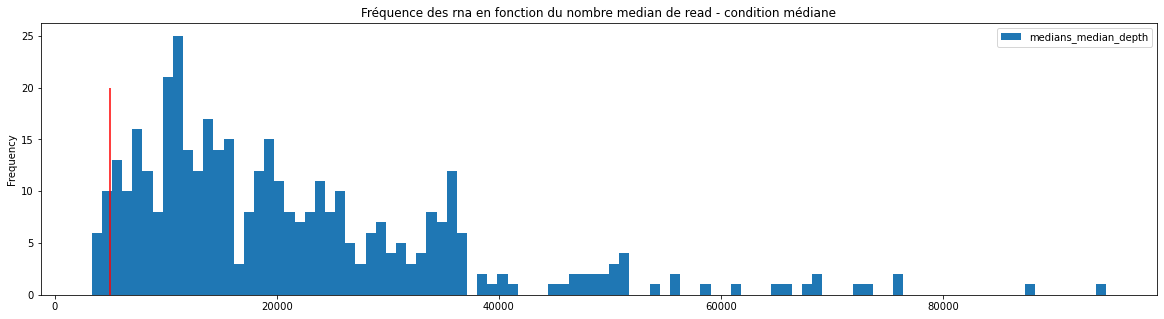

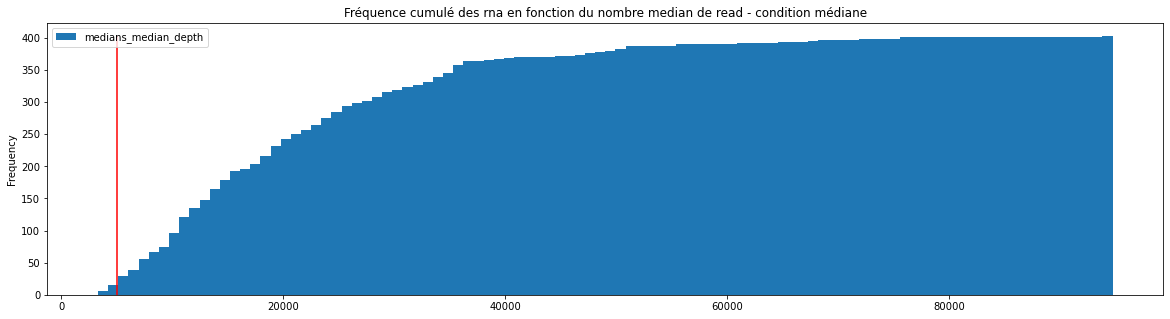

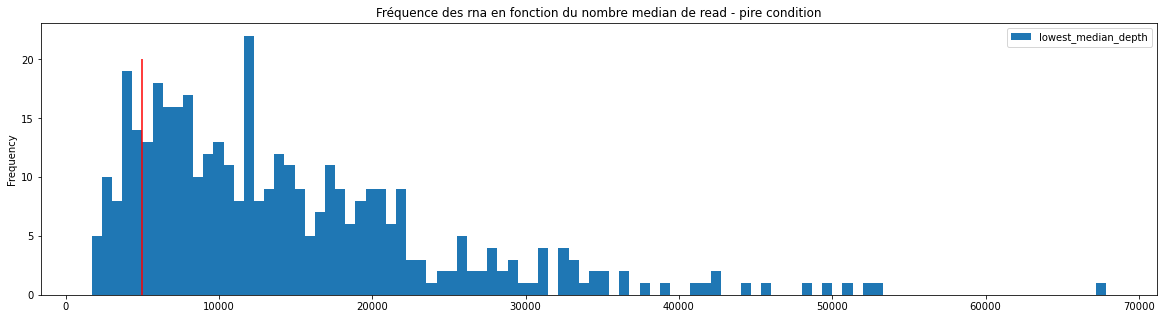

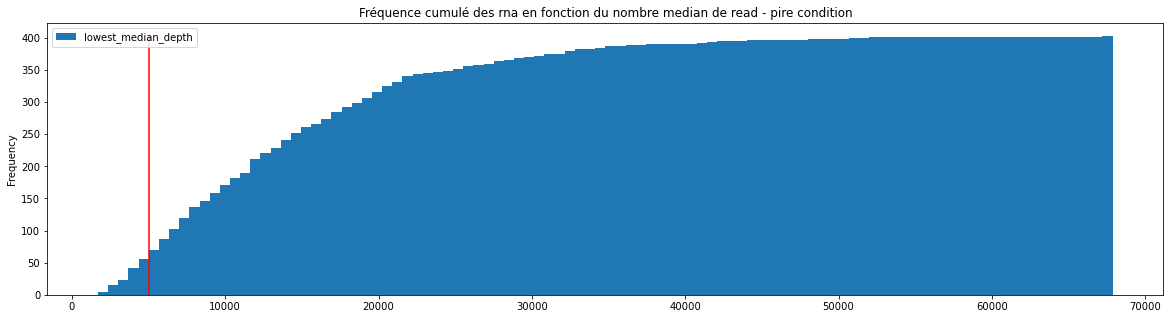

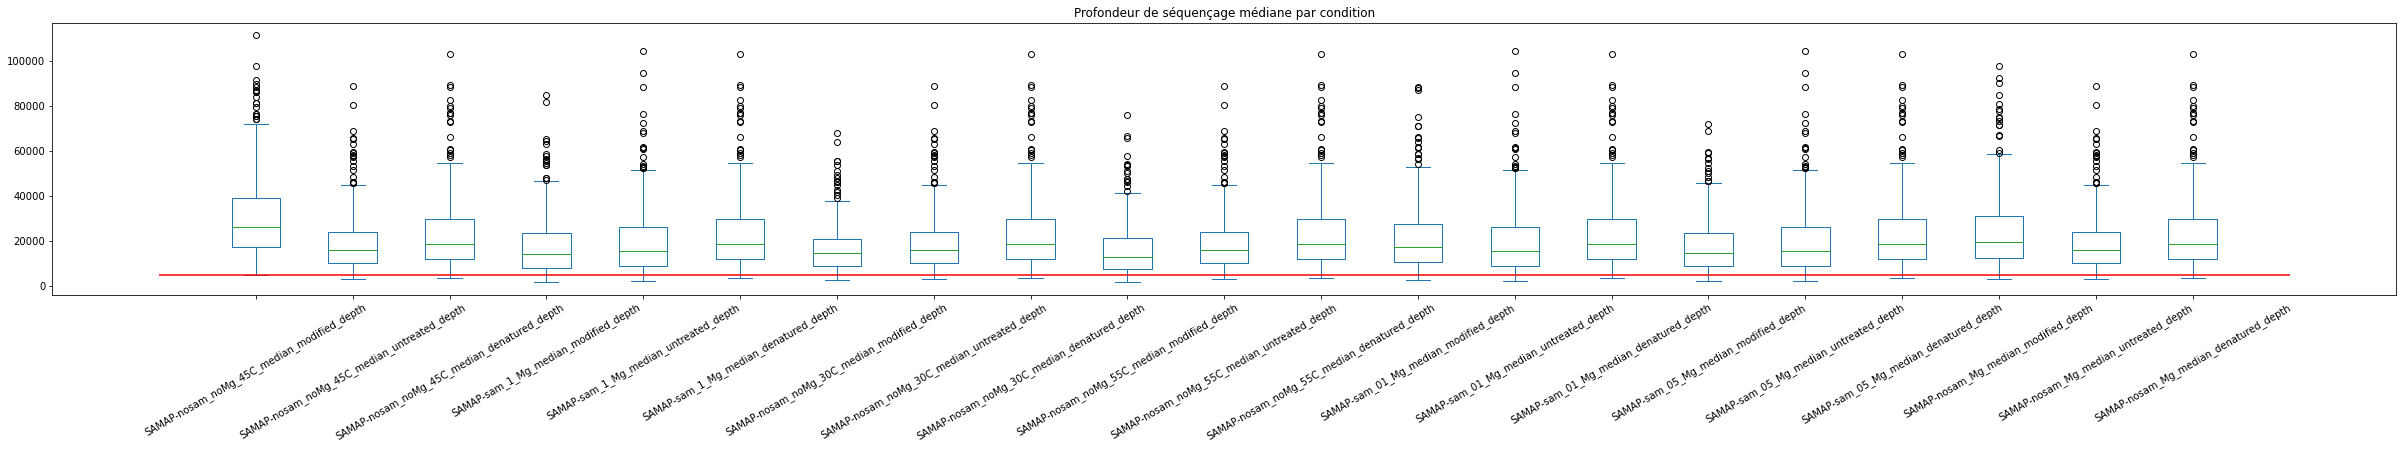

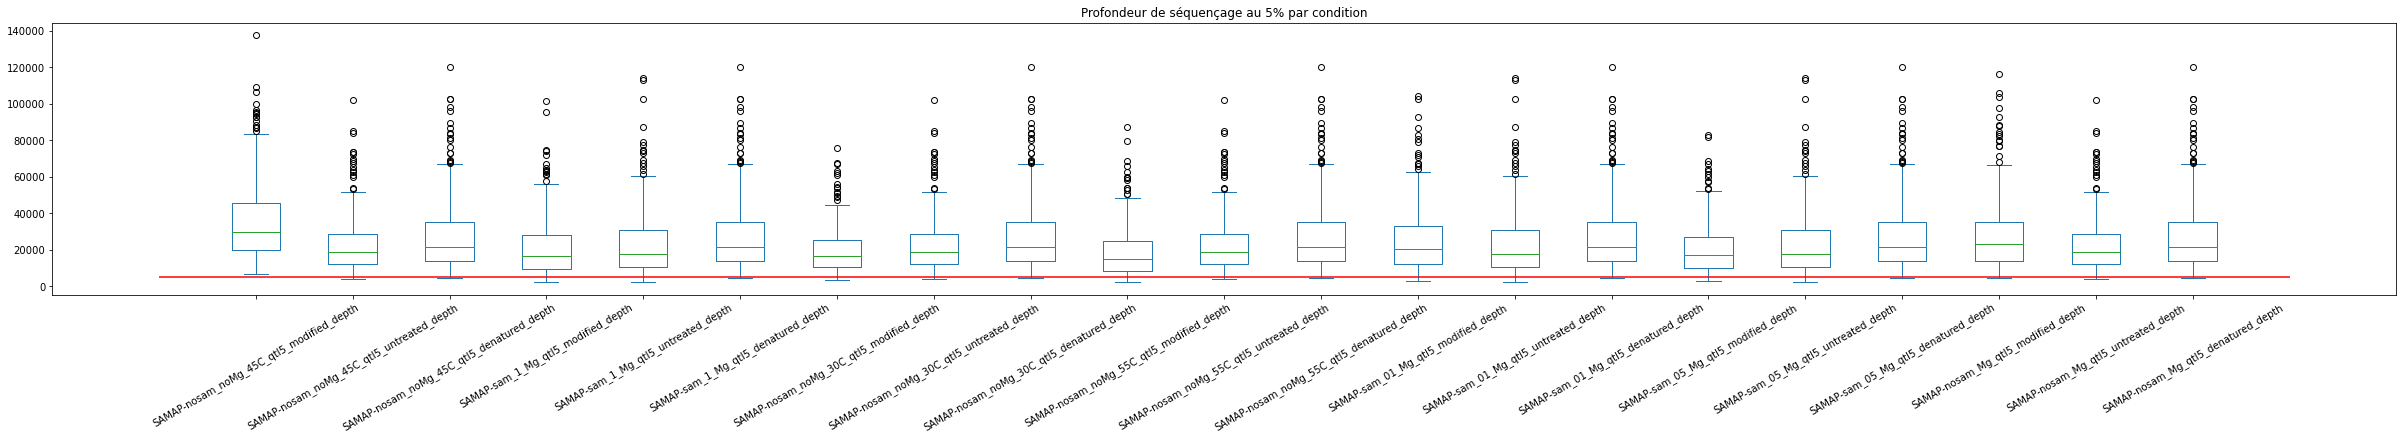

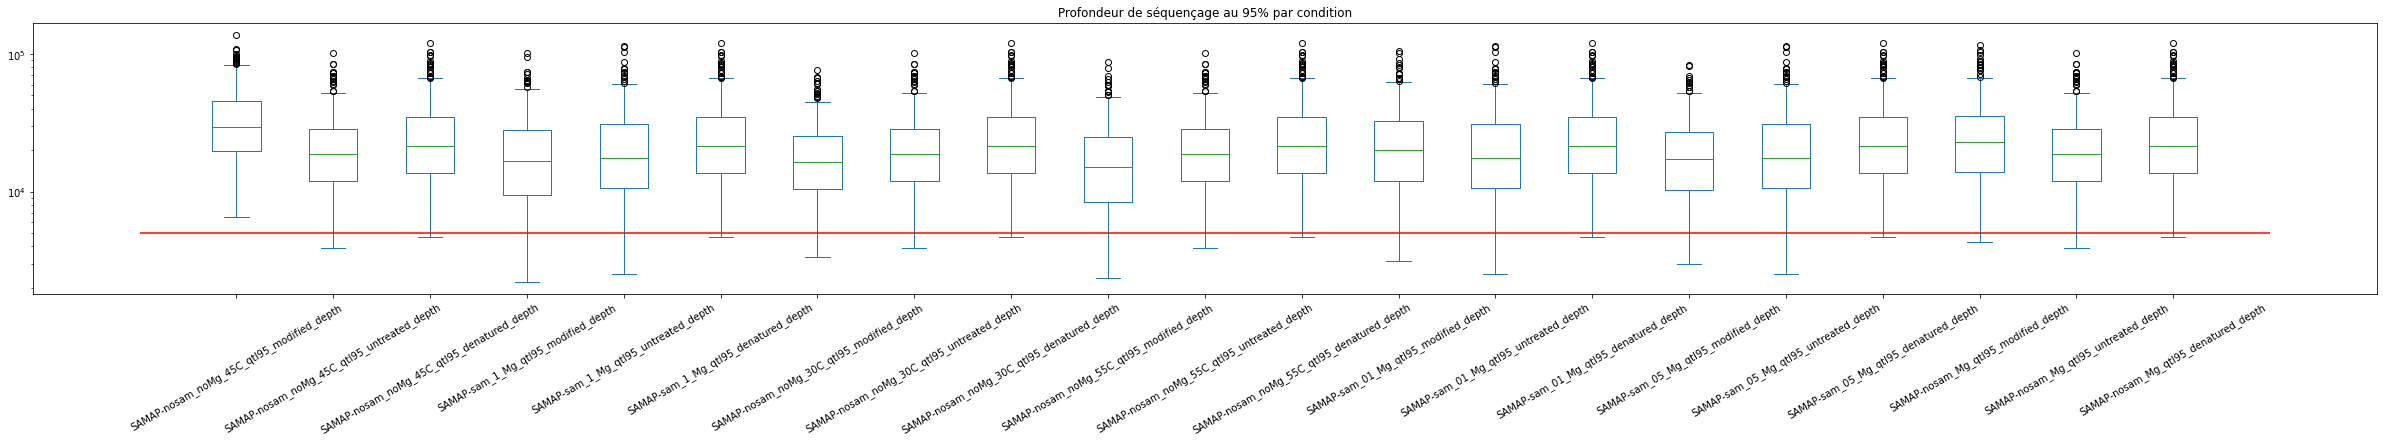

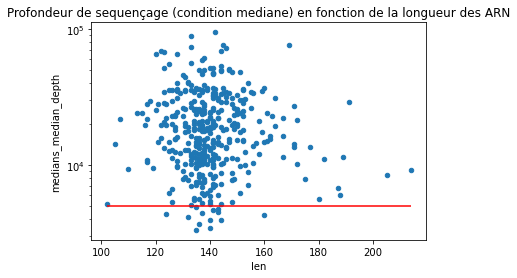

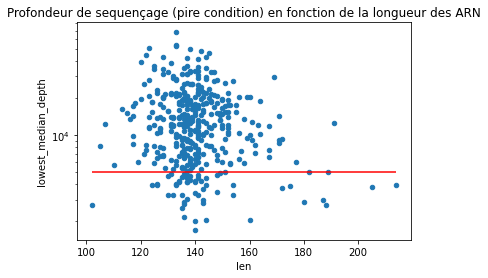

In [10]:
#print(df[depth])


# Histogramme des fréquence 
pd.DataFrame(df[median_depth[0]]).astype(float).describe()
ax = pd.DataFrame(df["medians_median_depth"]).astype(float).plot(kind="hist", bins=100, figsize=(20,5), title="Fréquence des rna en fonction du nombre median de read - condition médiane")
plt.vlines(5000, ymin=0, ymax=20, colors="red")
pd.DataFrame(df[median_depth[0]]).astype(float).describe()
ax = pd.DataFrame(df["medians_median_depth"]).astype(float).plot(kind="hist",cumulative=True, bins=100, figsize=(20,5), title="Fréquence cumulé des rna en fonction du nombre median de read - condition médiane")
plt.vlines(5000, ymin=0, ymax=df.shape[0], colors="red")


pd.DataFrame(df[median_depth[0]]).astype(float).describe()
ax = pd.DataFrame(df["lowest_median_depth"]).astype(float).plot(kind="hist", bins=100, figsize=(20,5), title="Fréquence des rna en fonction du nombre median de read - pire condition")
plt.vlines(5000, ymin=0, ymax=20, colors="red")

ax = pd.DataFrame(df["lowest_median_depth"]).astype(float).plot(kind="hist", bins=100,cumulative=True, figsize=(20,5), title="Fréquence cumulé des rna en fonction du nombre median de read - pire condition")
plt.vlines(5000, ymin=0, ymax=df.shape[0], colors="red")


ax = df[all_median_depth].astype(float).plot(kind="box", figsize=(df[all_median_depth].shape[1]*2,5), rot=30, title="Profondeur de séquençage médiane par condition")
plt.hlines(5000, xmin=0, xmax=df[all_median_depth].shape[1] + 1, colors="red")

ax = df[all_qtl5_depth].astype(float).plot(kind="box", figsize=(df[all_qtl5_depth].shape[1]*2,5), rot=30, title="Profondeur de séquençage au 5% par condition")
plt.hlines(5000, xmin=0, xmax=df[all_median_depth].shape[1] + 1, colors="red")

ax = df[all_qtl95_depth].astype(float).plot(kind="box", figsize=(df[all_qtl95_depth].shape[1]*2,5), rot=30, title="Profondeur de séquençage au 95% par condition")
plt.hlines(5000, xmin=0, xmax=df[all_median_depth].shape[1] + 1, colors="red")

ax.set_yscale('log')

# Frequence vs Longueurs
ax = df.plot(kind="scatter", y="medians_median_depth", x="len", title = "Profondeur de sequençage (condition mediane) en fonction de la longueur des ARN")
ax.set_yscale('log')
plt.hlines(5000, xmin=min(df["len"]), xmax=max(df["len"]), colors="red")

ax = df.plot(kind="scatter", y="lowest_median_depth", x="len", title = "Profondeur de sequençage (pire condition) en fonction de la longueur des ARN")
ax.set_yscale('log')
plt.hlines(5000, xmin=min(df["len"]), xmax=max(df["len"]), colors="red")




#plot_box(df)
#plot_box(df, columns="primer", title="Profondeur de séquençage (condition mediane) par primer",)    
#plot_box(df, values="lowest_median_depth",title="Profondeur de séquençage (pire condition) par source",)    
#plot_box(df, columns="primer", values="lowest_median_depth",title="Profondeur de séquençage (pire condition) par primer",)

#df = df.sort_values("source")
#plot_box(df, columns=["source","primer"], values="medians_median_depth",title="Profondeur de séquençage (condition mediane) par primer et source",rot=90, vert=True)

#df = df.sort_values("primer")
#plot_box(df, columns=["primer", "source"], values="medians_median_depth",title="Profondeur de séquençage (condition mediane) par primer et source",rot=90, vert=True)






/tmp/ipykernel_339926/1398604881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=df["name"], y=df[col],label=col, cmap="Set3", alpha=0.5)
/tmp/ipykernel_339926/1398604881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=df["name"], y=df[col],label=col, cmap="Set3", alpha=0.5)
/tmp/ipykernel_339926/1398604881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=df["name"], y=df[col],label=col, cmap="Set3", alpha=0.5)
/tmp/ipykernel_339926/1398604881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=df["name"], y=df[col],label=col, cmap="Set3", alpha=0.5)
/tmp/ipykernel_339926/1398604881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=df["name"], y=df[col],label=col, cmap="Set3", a

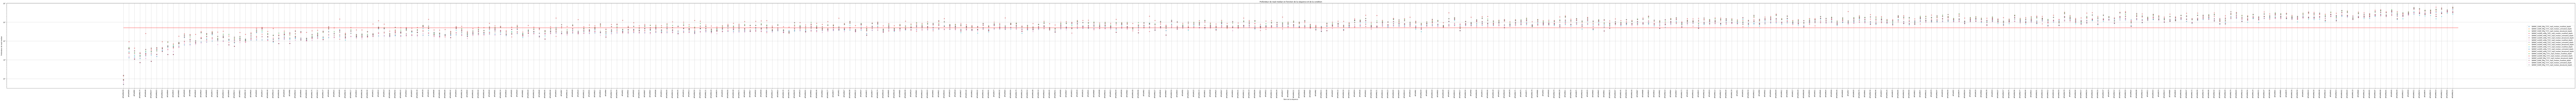

In [18]:

df = df.reset_index()
df = df.sort_values([ col for col in df.columns if "modified" in col][0])
f, ax = plt.subplots(figsize=(.6 * len(df.index),10))

for col in all_median_depth: #+ ["rep1-nosam_noMg_median_untreated_depth", "rep1-nosam_noMg_median_denatured_depth", "rep2-nosam_noMg_median_untreated_depth", "rep2-nosam_noMg_median_denatured_depth"]:
    plt.scatter(x=df["name"], y=df[col],label=col, cmap="Set3", alpha=0.5)
ax.set_yscale('log')
plt.xticks(rotation=90)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.hlines(5000, xmin=0, xmax=len(df.index), colors="red")
plt.legend(loc="center right", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylabel("Profondeur de read median")
plt.xlabel("Nom de la séquence")
plt.title("Profondeur de read median en fonction de la séquence et de la condition")
plt.set_cmap('Set3')
#plt.tight_layout()
plt.show()
df = df.set_index("name")
#display(df)

<AxesSubplot: ylabel='name'>

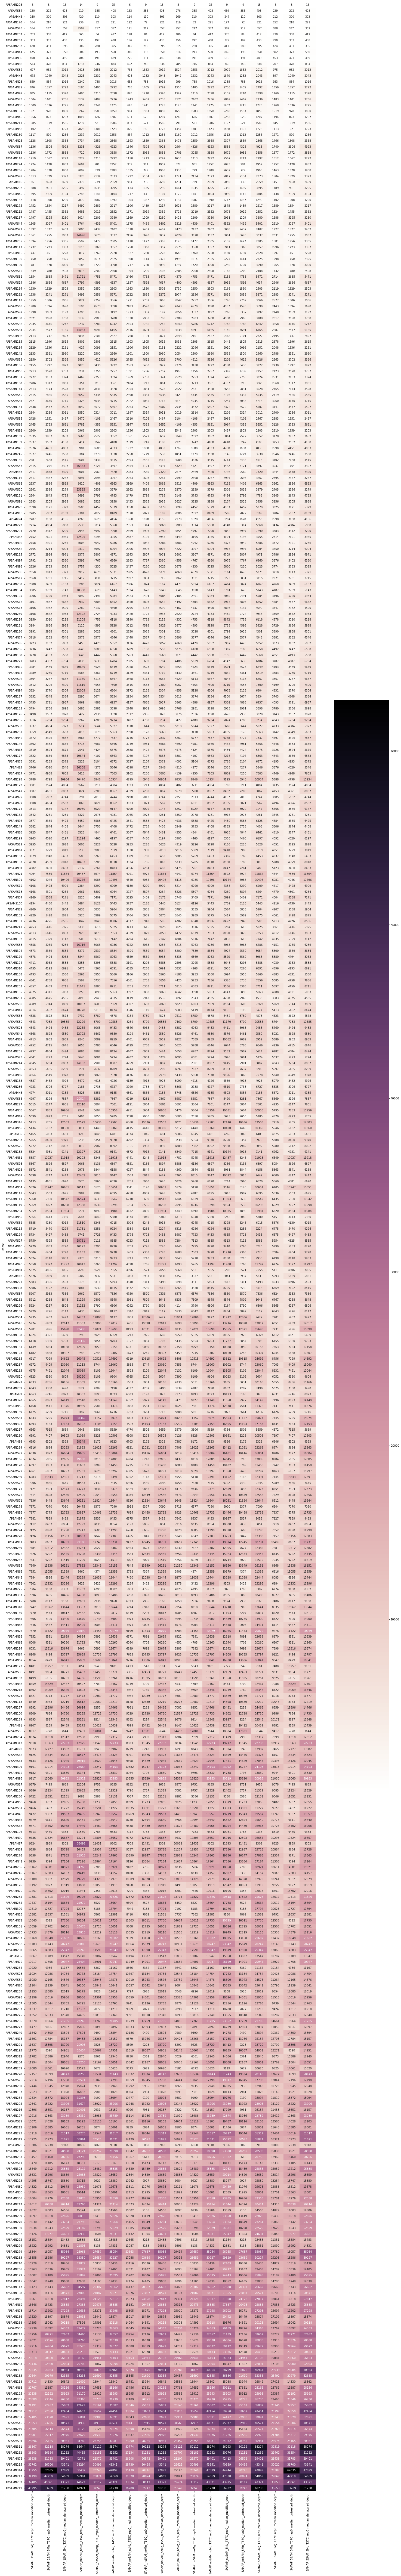

In [17]:
plt.figure(figsize=(4*len(conditions), len(df.index) * 0.4))
cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)
sns.heatmap(pd.DataFrame(df[all_median_depth].fillna(-1),dtype="int"), annot=True, fmt='g', cmap=cmap)


#display(df)